# Cognitive Science and AI: Assignment 1
## Predicting fMRI-based task-related activation with Machine Learning

    Soham Korade
    2021101131

In [1]:
!pip install nilearn
from nilearn import datasets

In [2]:
subj2 = datasets.fetch_haxby(subjects=(2,), fetch_stimuli=True)
subj2.keys()

dict_keys(['anat', 'func', 'session_target', 'mask_vt', 'mask_face', 'mask_house', 'mask_face_little', 'mask_house_little', 'mask', 'description', 'stimuli'])

In [3]:
import nibabel
func_img = nibabel.load(subj2['func'][0])
anat_img = nibabel.load(subj2['anat'][0])
print(func_img.shape)
print(anat_img.shape)
print(subj2['mask_vt'])

(40, 64, 64, 1452)
(124, 256, 256)
['/root/nilearn_data/haxby2001/subj2/mask4_vt.nii.gz']


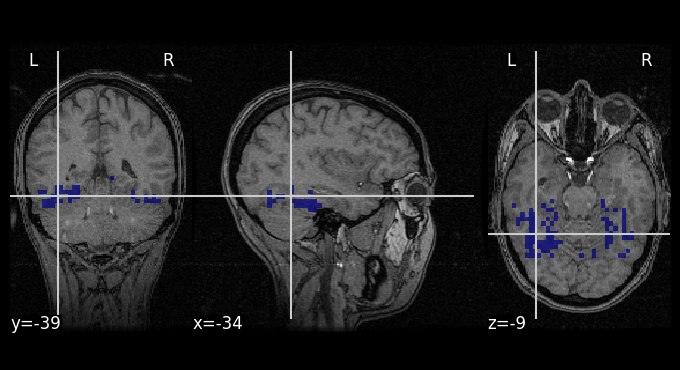

In [4]:
from nilearn import plotting
plotting.plot_roi(subj2['mask_vt'][0], bg_img=subj2['anat'][0], dim=-1)

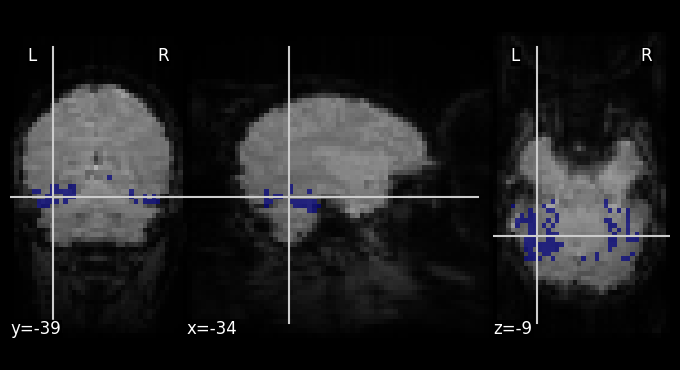

In [5]:
from nilearn import image
mean_img = image.mean_img(subj2['func'][0])
plotting.plot_roi(subj2['mask_vt'][0], bg_img=mean_img)

In [6]:
from nilearn.maskers import NiftiMasker
masker = NiftiMasker(mask_img=subj2['mask_vt'][0],
standardize="zscore_sample",
detrend=True,
high_variance_confounds=True)
time_series = masker.fit_transform(subj2['func'][0])

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


(1452, 464)


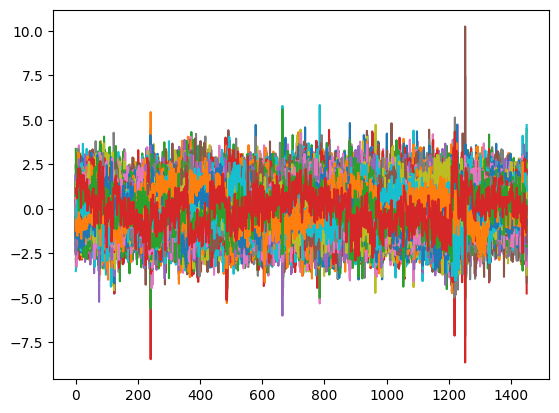

In [7]:
import matplotlib.pyplot as plt
print(time_series.shape)
plt.plot(time_series)
plt.show()

restrict the analysis to specific task conditions

 Load behavioral data for conditions specific analysis

In [8]:
import pandas as pd
behavioral = pd.read_csv(subj2['session_target'][0], sep=" ")
# Restrict to face, house conditions
conditions = behavioral["labels"]

In [9]:
condition_mask = conditions.isin(["face", "house"])
import numpy as np
condition_mask_array = np.array(condition_mask)
time_series[condition_mask_array].shape

(216, 464)

Classification

In [10]:
X = time_series[condition_mask_array]
y = conditions[condition_mask]
print(time_series.shape)
print(X.shape)
print(y.shape)
y.unique()

(1452, 464)
(216, 464)
(216,)


array(['face', 'house'], dtype=object)

 Simple cross-validation

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
from sklearn.svm import LinearSVC,SVC
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC()

In [12]:
predicted = svc.predict(X_test)

In [13]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, predicted))

1.0


Cross-validating on sessions

In [14]:
condition_mask_train = (condition_mask) & (behavioral["chunks"] <= 6)
condition_mask_test = (condition_mask) & (behavioral["chunks"] > 6)
print(condition_mask_train.shape)
print(condition_mask_test.shape)

(1452,)
(1452,)


In [15]:
X_train = time_series[condition_mask_train]
X_test = time_series[condition_mask_test]
y_train = conditions[condition_mask_train]
y_test = conditions[condition_mask_test]
svc.fit(X_train, y_train)
predicted = svc.predict(X_test)
print(accuracy_score(y_test, predicted))

0.9888888888888889


Assignment 1 begins here

I am in group 6 as per the allocations. So my "ROI/Region", "Subject",	"Contrast" are respectively "Inferior frontal", "Subj1", and "Scrambledpix".

I have downloaded VT for subj1 and saved as 'features_vt.csv' in Colab.
Also, Inferior Frontal ROI for subj is saved as 'features_inf_front.csv'. These files are loaded using pandas into a dataframe.

In [16]:
my_contrast="scrambledpix"

In [17]:
subj1 = datasets.fetch_haxby(subjects=(1,), fetch_stimuli=True)
subj1.keys()

dict_keys(['anat', 'func', 'session_target', 'mask_vt', 'mask_face', 'mask_house', 'mask_face_little', 'mask_house_little', 'mask', 'description', 'stimuli'])

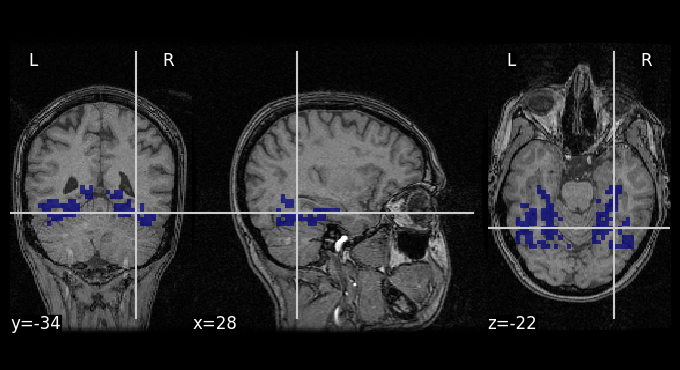

In [19]:
plotting.plot_roi(subj1['mask_vt'][0], bg_img=subj1['anat'][0], dim=-1)

In [20]:
masker = NiftiMasker(mask_img=subj1['mask_vt'][0],
standardize="zscore_sample",
detrend=True,
high_variance_confounds=True)
time_series = masker.fit_transform(subj1['func'][0])

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


In [21]:
behavioral = pd.read_csv(subj1['session_target'][0], sep=" ")
# Restrict to face, house conditions
conditions = behavioral["labels"]

In [22]:
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
import matplotlib.pyplot as plt

In [23]:
def do_cross_val(X,y,groups):
  # print(X.shape)
  # print(y.shape)
  # y.unique()

  loo = LeaveOneGroupOut()

  # Choose your machine learning model
  model = SVC(kernel='rbf')
  # Perform cross-validation
  accuracies = cross_val_score(model, X, y, groups=groups, cv=loo)

  # print(accuracies)

  return accuracies

VT

In [24]:
time_series_vt=pd.read_csv("features_vt.csv",sep=" ",header=None)
time_series_vt.head()

,0,1,2,3,4,5,6,7,8,9,...,567,568,569,570,571,572,573,574,575,576
0,-1.664274,-0.383935,-0.345129,-2.545765,-1.151102,1.102877,-0.130462,1.583393,-2.512390,-0.545169,...,-2.806759,-1.043368,-0.554739,2.333432,1.592921,1.823540,0.022978,0.845915,2.348397,2.421819
1,-1.130705,0.038555,-0.526865,-0.387543,-0.242571,0.633063,-0.022254,1.853271,-1.812403,-0.187315,...,-3.355018,-1.581770,-1.152469,0.976372,0.108978,0.710328,0.395105,-0.389683,2.386003,0.140732
2,-0.844545,0.021134,-0.451083,-1.048493,-1.101881,-0.458341,0.254783,1.914279,-1.305234,-0.333603,...,-2.760747,-1.181677,-1.195175,1.974175,0.853634,0.756655,-1.219155,1.144426,1.053198,1.177197
3,-0.400502,0.030478,-0.200253,-0.315391,-1.942959,0.636476,0.263368,1.709771,-1.621306,-0.011976,...,-1.726810,-0.236011,-0.872144,1.860907,0.968990,0.548525,-0.696282,0.065931,0.415453,1.923699
4,-0.109114,0.377499,0.074618,-0.188214,-1.495382,0.726194,0.440975,1.881013,-1.914509,-0.114311,...,-2.358681,-0.704712,-0.817561,1.662171,0.538017,0.580560,-0.831456,1.050611,1.409640,1.238922


vt

In [25]:
print(time_series_vt.shape)
print(conditions.shape)

(1452, 577)
(1452,)


In [26]:
def do_classification_for_voxels(voxels,voxel_name=""):
  # face vs house
  face_vs_house_cond_mask = conditions.isin(["face", "house"])
  face_vs_house_cond_mask_array = np.array(face_vs_house_cond_mask)

  X = voxels[face_vs_house_cond_mask]
  y = conditions[face_vs_house_cond_mask_array]
  groups = behavioral['chunks'][face_vs_house_cond_mask_array]
  ac1=do_cross_val(X,y,groups)

  # face vs X
  face_vs_X_cond_mask = conditions.isin(["face", my_contrast])
  face_vs_X_cond_mask_array = np.array(face_vs_X_cond_mask)

  X = voxels[face_vs_X_cond_mask]
  y = conditions[face_vs_X_cond_mask_array]
  groups = behavioral['chunks'][face_vs_X_cond_mask_array]
  # print(groups)
  ac2=do_cross_val(X,y,groups)

  all_accuracies = [ac1, ac2]

  # Labels for each boxplot
  labels = ['face vs house', 'face vs X']

  # Visualize results
  plt.figure(figsize=(8, 6))
  plt.boxplot(all_accuracies, labels=labels)
  plt.title(f"CrossVal Scores: {voxel_name}")
  plt.ylabel('Accuracy')
  plt.show()


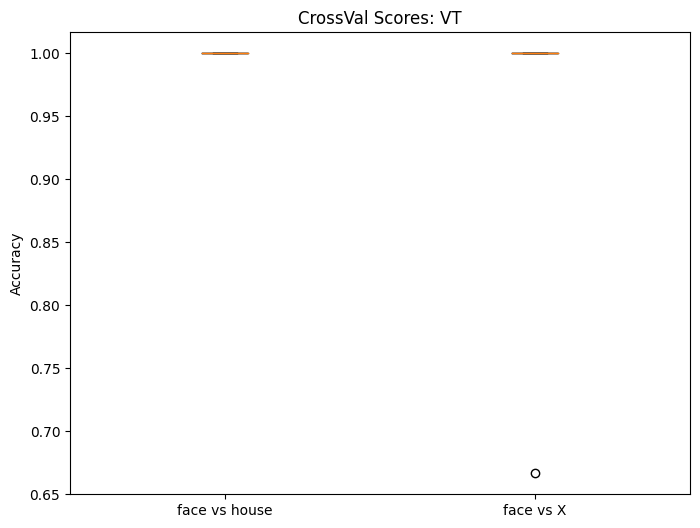

In [27]:
do_classification_for_voxels(time_series_vt,"VT")

VT with 50% random features

In [28]:
time_series_vt.index

RangeIndex(start=0, stop=1452, step=1)

In [29]:
random_50 = np.random.choice(time_series_vt.columns, int(len(time_series_vt.columns)*0.5), replace=False)
time_series_vt_subset = time_series_vt[random_50]

In [30]:
print(time_series_vt.shape)
print(time_series_vt_subset.shape)

(1452, 577)
(1452, 288)


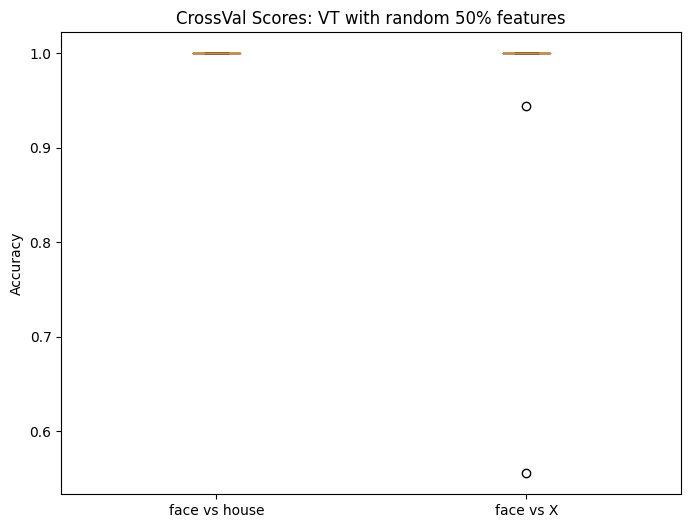

In [32]:
do_classification_for_voxels(time_series_vt_subset,"VT with random 50% features")

ROI

In [33]:
time_series_roi=pd.read_csv("features_inf_front.csv",sep=" ",header=None)

time_series_roi.head()

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,0.766689,-2.339242,-2.245956,-1.489453,-3.424119,-0.385256,-2.212765,1.359545,-2.668501,1.729837,...,0.906036,-1.210791,0.934228,-0.200557,0.436215,-0.506665,-0.002838,-0.207038,-0.406489,-0.783146
1,0.602334,-2.338546,-2.063928,-1.464332,-3.272194,-0.453013,-1.933958,1.416615,-0.828697,1.855547,...,0.626646,-1.887570,1.172753,-0.385166,1.017902,-0.506374,-0.088936,-0.269450,-0.490312,-1.013579
2,1.034236,-2.277009,-2.295647,-1.289161,-2.863014,0.767762,-1.716598,1.818532,-0.147667,1.783589,...,0.814450,-1.779808,1.950065,-0.400688,0.816380,-0.314604,-0.089434,-0.082947,-0.431565,-1.203170
3,1.195113,-1.196383,-2.645579,-1.234031,-1.467689,0.204416,-1.729663,1.588228,-0.625411,1.495993,...,1.209896,-1.850350,1.410344,-0.831243,0.798163,-0.582384,-0.207633,-0.249074,-0.393185,-1.433603
4,1.482468,-1.393421,-2.227124,-1.569029,-1.937465,0.400973,-1.527665,1.760247,-0.104212,2.106887,...,1.017023,-1.599944,1.369499,-0.600818,0.863265,-0.326788,-0.240231,-0.518916,-0.660314,-1.514281


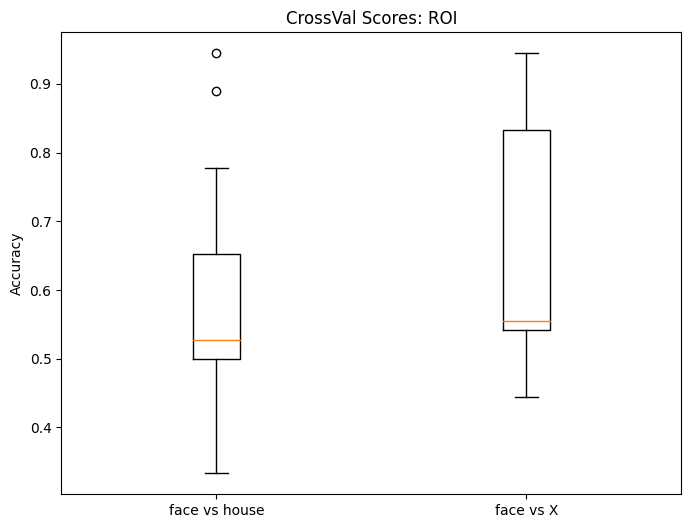

In [34]:
do_classification_for_voxels(time_series_roi,"ROI")

Discussion of the results:

X = scrambledpix

The ventral temporal cortices (VTC) are a part of the temporal lobe that are involved in visual object recognition and high-level visual processing. The VTC acts as a "ventral visual stream" that rapidly and flexibly categorizes visual stimuli. The VTC supports visual processing of important categories, such as faces and words. So, the accuracy is quite high.

In VT with 50% random features, we get a lesser accuracy than fully-featured VT because the model has more features to work with.

In ROI (inferior frontal gyrus), the cross validation accuracy is low because, that area is more involved in language processing and speech production. Broca's area lies in this region.

In [35]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [36]:
def plot_confusion_matrix(y_true, y_pred, title):
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.title(title)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()


In [37]:
# Function to train SVC models and make predictions
def train_and_predict(X, y, condition_name=""):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

  model = SVC(kernel='rbf')
  model.fit(X_train, y_train)

  # face vs house
  face_vs_house_cond_mask = y_test.isin(["face", "house"])
  face_vs_house_cond_mask_array = np.array(face_vs_house_cond_mask)

  X_test1 = X_test[face_vs_house_cond_mask]
  y_test1 = y_test[face_vs_house_cond_mask_array]

  y_pred1 = model.predict(X_test1)

  # Visualize confusion matrix
  plot_confusion_matrix(y_test1, y_pred1, f"face vs house: Confusion Matrix for {condition_name}")
  ac1 = np.mean(y_pred1 == y_test1)

  # face vs X
  face_vs_X_cond_mask = y_test.isin(["face", my_contrast])
  face_vs_X_cond_mask_array = np.array(face_vs_X_cond_mask)

  X_test2 = X_test[face_vs_X_cond_mask]
  y_test2 = y_test[face_vs_X_cond_mask_array]

  y_pred2 = model.predict(X_test2)

  # Visualize confusion matrix
  plot_confusion_matrix(y_test2, y_pred2, f"face vs X: Confusion Matrix for {condition_name}")

  ac2 = np.mean(y_pred2 == y_test2)
  print(f"Accuracy for face vs house: {condition_name}: {ac1}")
  print(f"Accuracy for face vs X: {condition_name}: {ac2}")
  return ac1,ac2

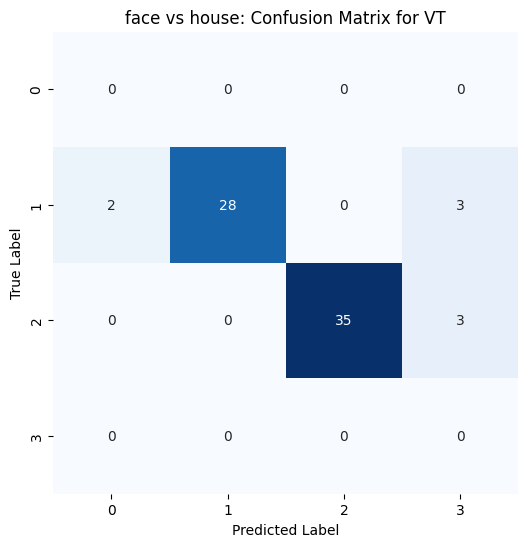

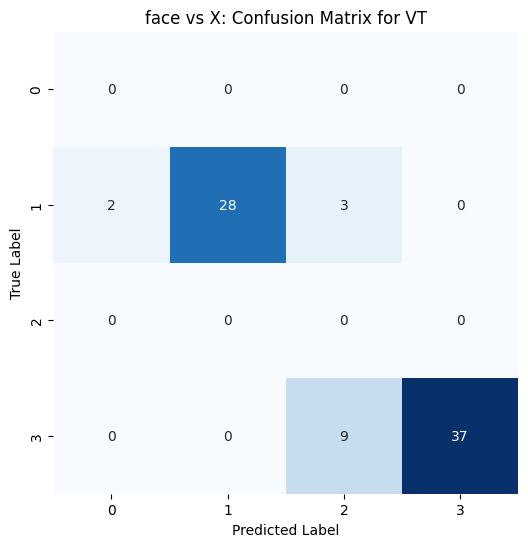

Accuracy for face vs house: VT: 0.8873239436619719
Accuracy for face vs X: VT: 0.8227848101265823


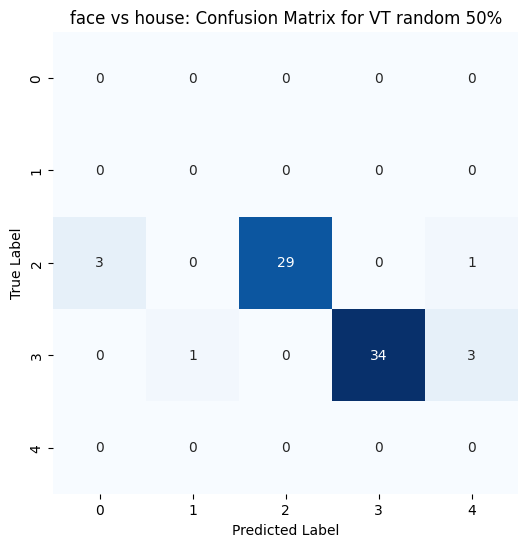

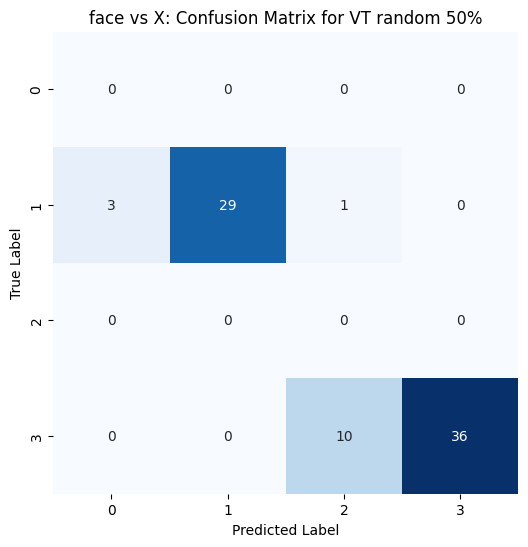

Accuracy for face vs house: VT random 50%: 0.8873239436619719
Accuracy for face vs X: VT random 50%: 0.8227848101265823


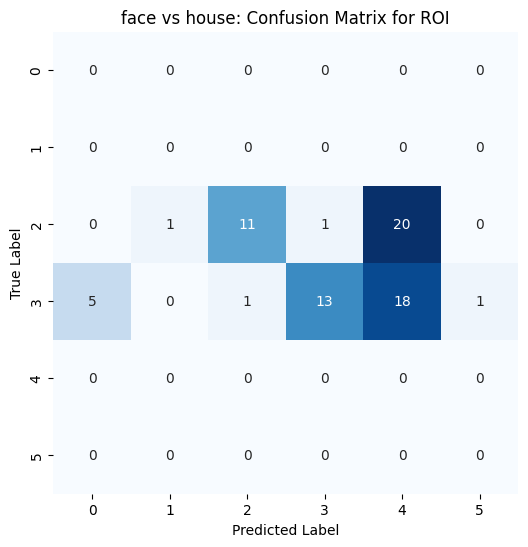

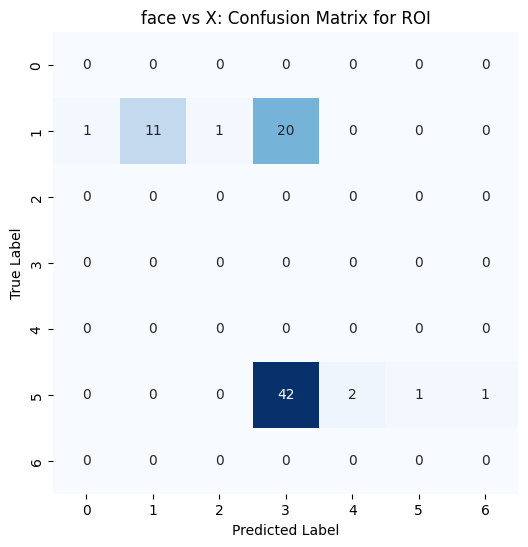

Accuracy for face vs house: ROI: 0.3380281690140845
Accuracy for face vs X: ROI: 0.1518987341772152


In [38]:
vt_acc=train_and_predict(time_series_vt,conditions,"VT")
vt50_acc=train_and_predict(time_series_vt_subset,conditions,"VT random 50%")
vtroi_acc=train_and_predict(time_series_roi,conditions,"ROI")

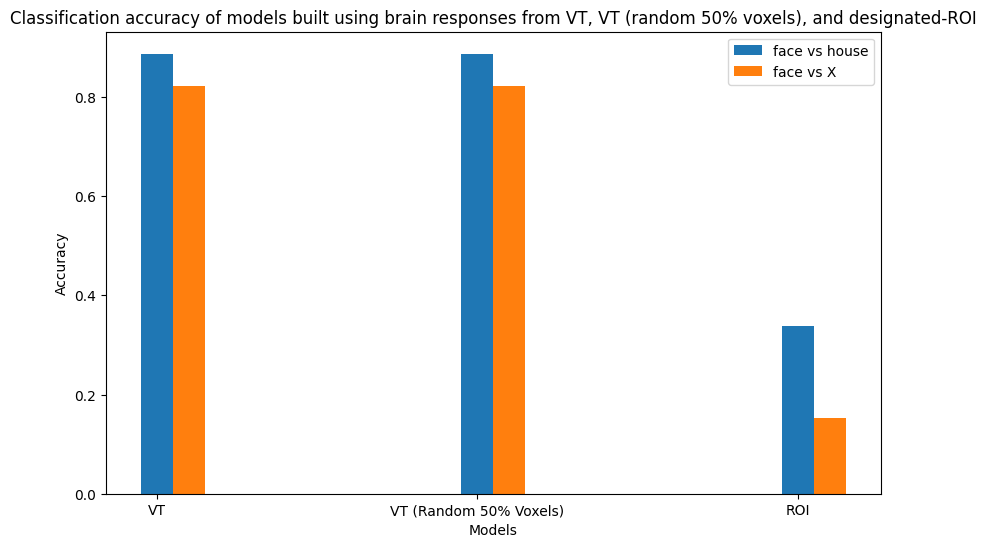

In [39]:
models = ['VT', 'VT (Random 50% Voxels)', 'ROI']
bar_width = 0.1

# plot bar graph
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the sub-bars for each condition
bar1 = ax.bar(np.arange(len(models)), [vt_acc[0], vt50_acc[0], vtroi_acc[0]], width=bar_width, label='face vs house')

# Add the sub-bars for the second accuracy values
ax.bar(np.arange(len(models)) + bar_width, [vt_acc[1], vt50_acc[1], vtroi_acc[1]], width=bar_width, label='face vs X')

# plot config
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Classification accuracy of models built using brain responses from VT, VT (random 50% voxels), and designated-ROI')
ax.set_xticks(np.arange(len(models)))
ax.set_xticklabels(models)
ax.legend()

plt.show()

We observe that ROI (inferior frontal cortex) has significantly lesser accuracy than VT and VT random 50%.

VT and VT random 50% accuracies are almost the same, this may indicate that feature vector may contain redundant or highly correlated features. Removing some of them doesn't significantly affect the model's performance because the remaining features still capture similar information (the task maybe relatively simple).

Also some features in the original vector might be noise or irrelevant to the task. By randomly selecting 50% of the features, we might be removing noisy or irrelevant information, resulting in similar model performance.

Overfitting can also be the reason. By reducing the number of features, we might be regularizing the model and preventing overfitting, leading to similar accuracies.

